In [3]:
# !pip install seaborn

In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

$$
P(Z|X) = \frac{P(X|Z)P(Z)}{P(X)}
$$
- 经典变分贝叶斯的核心思想是：既然算不出真实的后验 $P(Z|X)$，那我们找一个简单的、好计算的分布 $Q(Z)$ 来近似它
$$
ELBO(Q) = \mathbb{E}_{Q(Z)}[\log P(X|Z)] - KL(Q(Z) || P(Z))
$$
- 如何让 $Q(Z)$ 变得简单，典 VB 通常采用平均场假设 (Mean-field Assumption)，即假设 $Z$ 的所有维度是相互独立的；
    - $Q(Z)=\Pi_{i=1}^Mq_i(z_i)$

| 特征 | 经典变分贝叶斯 (VB) | 变分自编码器 (VAE) |
| :--- | :--- | :--- |
| **核心目标** | **推断 (Inference)**：为给定的数据和模型，近似计算复杂的后验分布 $P(Z\|X)$。 | **生成 (Generation)**：学习数据的潜在表示，并用它来生成新的数据。 |
| **模型形式** | 通常是概率图模型 (Probabilistic Graphical Models)，分布形式有明确假设。 | 使用**深度神经网络**（编码器和解码器）来参数化概率分布。 |
| **近似方式** | 对每个数据点，通过迭代优化（如坐标上升）找到一个**特定的**近似分布 $Q(Z)$。 | 学习一个**摊销的 (Amortized)** 推断网络 $Q_\phi(Z\|X)$，可以为任何输入 $X$ 快速计算出近似分布。 |
| **优化方法** | 坐标上升变分推断 (CAVI) 等迭代算法。 | **随机梯度下降 (SGD)** 和反向传播。 |
| **关键技术** | **平均场假设** (使优化可行)。 | **重参数技巧** (使采样过程可导) 和 **摊销推断** (提高效率)。 |
| **应用领域** | 贝叶斯统计、主题模型 (LDA)、混合模型等。 | 图像生成、文本生成、药物发现、表示学习、异常检测等深度学习领域。 |

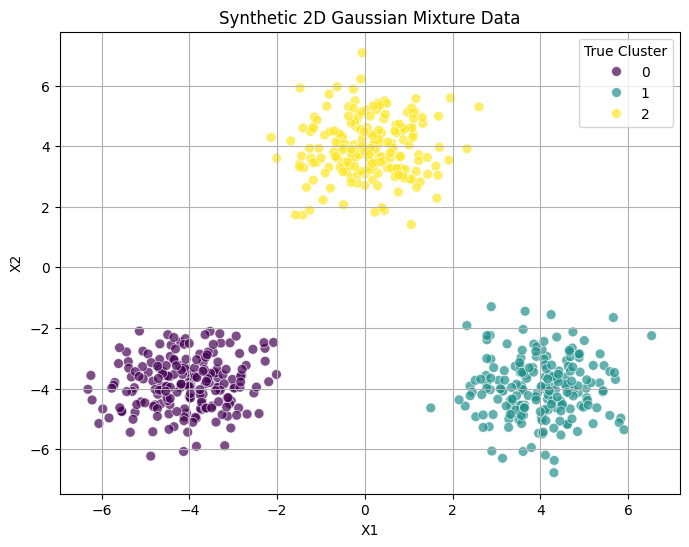

In [5]:

# 设置随机种子以保证结果可复现
torch.manual_seed(42)

# 1. 生成合成数据
def generate_data():
    # 定义三个簇的真实均值
    true_means = torch.tensor([[-4.0, -4.0], [4.0, -4.0], [0.0, 4.0]])
    # 定义协方差（为简单起见，各向同性）
    true_cov = torch.eye(2) * 0.8
    
    data_points = []
    labels = []
    
    # 从每个簇中采样200个点
    for i in range(3):
        # 使用多维正态分布进行采样
        dist = torch.distributions.MultivariateNormal(true_means[i], true_cov)
        data_points.append(dist.sample((200,)))
        labels.append(torch.full((200,), i))
        
    X = torch.cat(data_points, dim=0)
    Y = torch.cat(labels, dim=0)
    return X, Y

X, Y = generate_data()

# 可视化数据
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0].numpy(), y=X[:, 1].numpy(), hue=Y.numpy(), palette='viridis', s=50, alpha=0.7)
plt.title("Synthetic 2D Gaussian Mixture Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(title="True Cluster")
plt.grid(True)

### classic variational bayes

- 推断出每个点属于哪个高斯分布（潜在变量 Z），以及每个高斯分布的均值（模型参数 $\mu$）
- 模型: $P(X, Z, \mu) = P(X|Z, \mu)P(Z)P(\mu)$
    - $\mu_k \sim P(\mu) = \mathcal{N}(0, I)$
    - 对于每个数据点 $n$，它的簇分配 $Z_n$ 从一个类别分布中采样 $Z_n \sim P(Z) = \text{Categorical}(1/K, ..., 1/K)$
    - 数据点 $X_n$ 根据其分配的簇生成：$X_n \sim P(X|Z_n=k, \mu_k) = \mathcal{N}(X_n | \mu_k, I)$
- 近似后验: $Q(Z, \mu) = Q(Z)Q(\mu)$（平均场假设）
    - $Q(Z, \mu) \approx P(Z, \mu | X)$
    - $Q(Z, \mu) = Q(Z)Q(\mu) = \left( \prod_{n=1}^N Q(Z_n) \right) \left( \prod_{k=1}^K Q(\mu_k) \right)$
    - $Q(Z_n)$  是一个类别分布，由参数 $\gamma_{nk}$ 定义，其中 $\gamma_{nk}$ 代表数据点 $n$ 属于簇 $k$ 的概率（也称为责任 responsibility）。
    - $Q(\mu_k)$ 是一个高斯分布，由其自身的均值 $m_k$ 和协方差 $S_k$ 定义：$Q(\mu_k) = \mathcal{N}(\mu_k | m_k, S_k)$
- E-Step: 更新 $Q(Z)$，即计算每个数据点属于每个簇的“责任”(responsibility)。
- M-Step: 更新 $Q(\mu)$，即根据“责任”更新每个簇的均值参数的后验分布。

In [6]:
def run_classic_vb(X, n_clusters=3, n_iterations=20):
    """
    使用坐标上升变分推断 (CAVI) 对高斯混合模型进行经典变分贝叶斯推断。
    为简单起见，我们假设协方差是已知的单位矩阵。
    我们只推断簇的分配 (Z) 和簇的均值 (mu)。
    """
    n_samples, n_features = X.shape
    
    # --- 初始化变分参数 ---
    # 1. 簇均值 mu_k 的变分分布 q(mu_k) ~ N(mean, cov)
    # 随机初始化均值的后验均值
    vb_mu_means = torch.randn(n_clusters, n_features) * 2
    # 均值的后验协方差，初始化为单位阵
    vb_mu_covs = torch.eye(n_features).unsqueeze(0).repeat(n_clusters, 1, 1)

    # 2. 簇分配 Z_n 的变分分布 q(Z_n) 是一个类别分布
    # 初始化责任 (responsibilities) gamma_nk = q(Z_n=k)
    gamma_nk = torch.ones(n_samples, n_clusters) / n_clusters

    print("--- 开始经典变分贝叶斯 (CAVI) 迭代 ---")
    elbo_history = []

    for i in range(n_iterations):
        # --- E-Step: 更新 gamma_nk (q(Z)) ---
        # 计算 E[log p(X_n | Z_n=k, mu_k)]
        log_likelihood_terms = torch.zeros(n_samples, n_clusters)
        for k in range(n_clusters):
            # E[(x_n - mu_k)^T(x_n - mu_k)] = ||x_n - E[mu_k]||^2 + Tr(Var[mu_k])
            dist_sq = torch.sum((X.unsqueeze(1) - vb_mu_means).pow(2), dim=2)
            trace_var = torch.trace(vb_mu_covs[k])
            log_likelihood_terms[:, k] = -0.5 * (dist_sq[:, k] + trace_var)
        
        # 加上先验 log p(Z_n=k)，这里假设是均匀的
        log_gamma_nk = log_likelihood_terms + torch.log(torch.tensor(1.0 / n_clusters))
        
        # 归一化得到新的 gamma_nk
        log_gamma_nk_normalized = log_gamma_nk - torch.logsumexp(log_gamma_nk, dim=1, keepdim=True)
        gamma_nk = torch.exp(log_gamma_nk_normalized)

        # --- M-Step: 更新 vb_mu_means 和 vb_mu_covs (q(mu)) ---
        # 计算每个簇的总责任
        N_k = torch.sum(gamma_nk, dim=0) # shape: [n_clusters]
        
        # 更新均值的后验协方差 (假设先验协方差是单位阵)
        # 假设 mu 的先验是 N(0, I)
        prior_cov_inv = torch.eye(n_features)
        vb_mu_covs = torch.inverse(prior_cov_inv + N_k.view(-1, 1, 1) * torch.eye(n_features))
        
        # 更新均值的后验均值
        sum_gamma_x = torch.einsum('nk,nd->kd', gamma_nk, X) # shape: [n_clusters, n_features]
        vb_mu_means = torch.einsum('kdd,kd->kd', vb_mu_covs, sum_gamma_x)

        print(f"迭代 {i+1}/{n_iterations}, 推断出的簇均值: \n{vb_mu_means.round(decimals=2)}")

    print("\n--- 经典VB完成 ---")
    return vb_mu_means, gamma_nk

In [7]:
vb_means, vb_gamma = run_classic_vb(X)

--- 开始经典变分贝叶斯 (CAVI) 迭代 ---
迭代 1/20, 推断出的簇均值: 
tensor([[ 3.9200, -3.8600],
        [-3.7300, -2.9800],
        [ 0.3200,  3.9600]])
迭代 2/20, 推断出的簇均值: 
tensor([[ 3.9800, -3.9600],
        [-4.0600, -3.8300],
        [ 0.0900,  3.9100]])
迭代 3/20, 推断出的簇均值: 
tensor([[ 3.9800, -3.9600],
        [-4.0600, -3.8300],
        [ 0.0900,  3.9100]])
迭代 4/20, 推断出的簇均值: 
tensor([[ 3.9800, -3.9600],
        [-4.0600, -3.8300],
        [ 0.0900,  3.9100]])
迭代 5/20, 推断出的簇均值: 
tensor([[ 3.9800, -3.9600],
        [-4.0600, -3.8300],
        [ 0.0900,  3.9100]])
迭代 6/20, 推断出的簇均值: 
tensor([[ 3.9800, -3.9600],
        [-4.0600, -3.8300],
        [ 0.0900,  3.9100]])
迭代 7/20, 推断出的簇均值: 
tensor([[ 3.9800, -3.9600],
        [-4.0600, -3.8300],
        [ 0.0900,  3.9100]])
迭代 8/20, 推断出的簇均值: 
tensor([[ 3.9800, -3.9600],
        [-4.0600, -3.8300],
        [ 0.0900,  3.9100]])
迭代 9/20, 推断出的簇均值: 
tensor([[ 3.9800, -3.9600],
        [-4.0600, -3.8300],
        [ 0.0900,  3.9100]])
迭代 10/20, 推断出的簇均值: 
tensor([[ 3.9800

In [14]:
# [[-4.0, -4.0], [4.0, -4.0], [0.0, 4.0]])
vb_means, vb_gamma

(tensor([[ 3.9803, -3.9635],
         [-4.0551, -3.8266],
         [ 0.0905,  3.9132]]),
 tensor([[1.2978e-08, 1.0000e+00, 2.2429e-10],
         [1.2624e-11, 1.0000e+00, 7.8806e-23],
         [2.2962e-12, 1.0000e+00, 1.4360e-20],
         ...,
         [1.7386e-18, 1.6964e-20, 1.0000e+00],
         [2.4037e-21, 5.7622e-25, 1.0000e+00],
         [3.6711e-22, 2.1048e-22, 1.0000e+00]]))

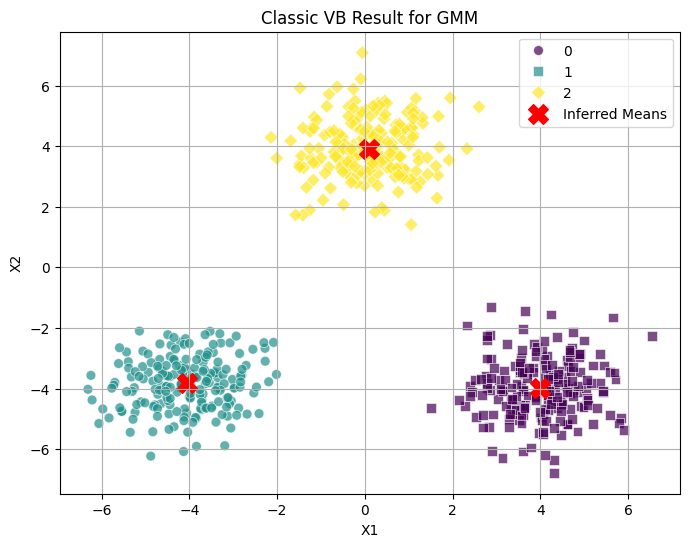

In [8]:
# 可视化结果
predicted_labels = torch.argmax(vb_gamma, dim=1)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0].numpy(), y=X[:, 1].numpy(), hue=predicted_labels.numpy(), palette='viridis', s=50, alpha=0.7, style=Y.numpy(), markers=['o', 's', 'D'])
plt.scatter(vb_means[:, 0].numpy(), vb_means[:, 1].numpy(), c='red', s=200, marker='X', label='Inferred Means')
plt.title("Classic VB Result for GMM")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)

### VAE

学习一个编码器，能将数据点映射到一个低维潜在空间；以及一个解码器，能从潜在空间中的点生成原始数据。我们将观察 VAE 是否能在其潜在空间中自动地将不同的簇分离开。

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [10]:
class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, hidden_dim=32):
        super(VAE, self).__init__()
        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim) # 输出重构的数据
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = self.fc_mu(h), self.fc_log_var(h)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

def vae_loss_function(x_recon, x, mu, log_var):
    # 1. 重构损失 (Reconstruction Loss)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    # 2. KL散度损失 (KL Divergence)
    # KL(Q(Z|X) || P(Z)), P(Z) is N(0, I)
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_loss

def run_vae(X, Y, latent_dim=2, epochs=50, batch_size=64, lr=1e-3):
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = VAE(input_dim=X.shape[1], latent_dim=latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("\n--- 开始 VAE 训练 ---")
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            optimizer.zero_grad()
            
            # 前向传播
            recon_batch, mu, log_var = model(data)
            
            # 计算损失
            loss = vae_loss_function(recon_batch, data, mu, log_var)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataset)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    print("--- VAE 训练完成 ---")
    
    # 获取所有数据的潜在表示
    model.eval()
    with torch.no_grad():
        _, latent_mu, _ = model(X)
    return latent_mu

In [11]:
latent_representation = run_vae(X, Y)


--- 开始 VAE 训练 ---
Epoch 10/50, Average Loss: 15.3548
Epoch 20/50, Average Loss: 7.4013
Epoch 30/50, Average Loss: 4.8438
Epoch 40/50, Average Loss: 4.2557
Epoch 50/50, Average Loss: 4.0572
--- VAE 训练完成 ---


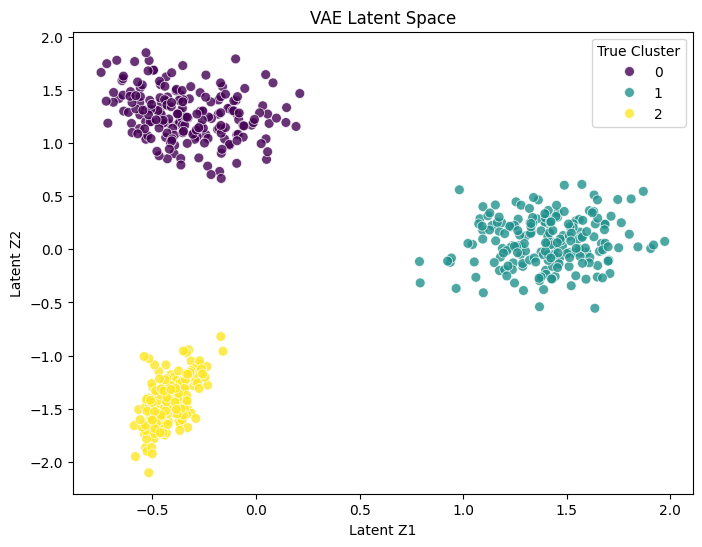

In [12]:
# 可视化潜在空间
plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_representation[:, 0].numpy(), y=latent_representation[:, 1].numpy(), hue=Y.numpy(), palette='viridis', s=50, alpha=0.8)
plt.title("VAE Latent Space")
plt.xlabel("Latent Z1")
plt.ylabel("Latent Z2")
plt.legend(title="True Cluster")